In [6]:
import pandas as pd
import seaborn as sns

In [5]:
df = pd.read_csv("../data/final_df/boost.csv")
df.drop(columns="Unnamed: 0", inplace = True)
df = df[(df["message"].str.lower() != "\u200eaudio ") & (df["message"].str.lower() != "\u200evideo ")& (df["message"].str.lower() != "\u200eimage ")]

<Axes: xlabel='emotions', ylabel='count'>

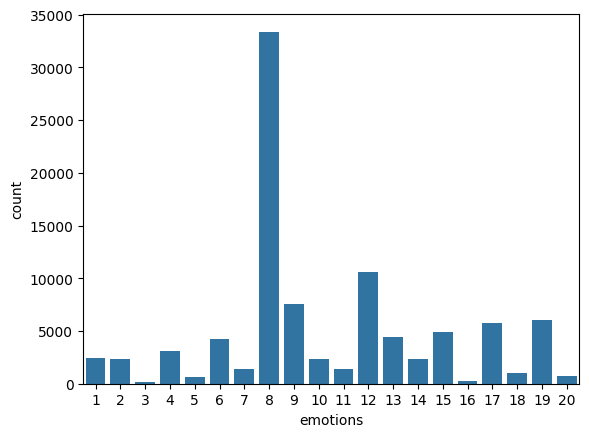

In [7]:
sns.countplot(x=df.emotions)